# redshift success rates
$z$-success is roughly a function $r$ band fiber magnitude and TSNR2 of the spectra. In this notebook, I'll fit

$$f_z(r_{\rm fib}, {\rm TSNR2})$$

In [1]:
import os
import tqdm
import fitsio
import numpy as np
import scipy.optimize as op
from scipy.special import erf
from desitarget.sv3.sv3_targetmask import bgs_mask as sv3_bgs_mask

In [2]:
os.sys.path.append(os.getcwd().replace('/nb', '/src'))
import svda as SVDA

In [3]:
import corner as DFM
import matplotlib.pyplot as plt


Bad key text.latex.preview in file /global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file /global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file /global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 418 ('savefig.jpeg_quality: 95 

# BGS Bright

Lets first focus on the $z$ success rates of BGS Bright

In [4]:
# file from /global/cfs/cdirs/desi/spectro/redux/everest/zcatalog/ztile-sv3-bright-cumulative.fits
# fuji couldn't be downloaded for some reason
ff = fitsio.read('/global/cfs/cdirs/desi/spectro/redux/fuji/zcatalog/ztile-sv3-bright-cumulative.fits')

In [5]:
# select only BGS targets
is_bgs = ((ff['COADD_FIBERSTATUS'] == 0) & 
          ((ff['SV3_BGS_TARGET'] & sv3_bgs_mask['BGS_BRIGHT']) != 0) & 
          (ff['SPECTYPE'] == 'GALAXY') & 
          (ff['Z'] > 0.) & (ff['Z'] < 0.6))
ff = ff[is_bgs]
print('%i objects' % ff.shape[0])

233831 objects


In [6]:
zsuccess = ((ff['ZWARN'] == 0) & 
            (ff['DELTACHI2'] > 40.) & 
            (ff['ZERR'] < 0.0005 * (1 + ff['Z'])))
print('%i z-success' % np.sum(zsuccess))

229917 z-success


In [7]:
photsys = ff['PHOTSYS'].astype(str)
trans_g = SVDA.mwdust_transmission(ff['EBV'], 'g', photsys, match_legacy_surveys=False)
trans_r = SVDA.mwdust_transmission(ff['EBV'], 'r', photsys, match_legacy_surveys=False)
trans_z = SVDA.mwdust_transmission(ff['EBV'], 'z', photsys, match_legacy_surveys=False)

flux_g = ff['FLUX_G'] / trans_g
flux_r = ff['FLUX_R'] / trans_r
flux_z = ff['FLUX_Z'] / trans_z
fiberflux_r = ff['FIBERFLUX_R'] / trans_r

In [8]:
gmag = 22.5 - 2.5 * np.log10(flux_g.clip(1e-7))
rmag = 22.5 - 2.5 * np.log10(flux_r.clip(1e-7))
zmag = 22.5 - 2.5 * np.log10(flux_z.clip(1e-7))

rfib = 22.5 - 2.5 * np.log10(fiberflux_r.clip(1e-7))

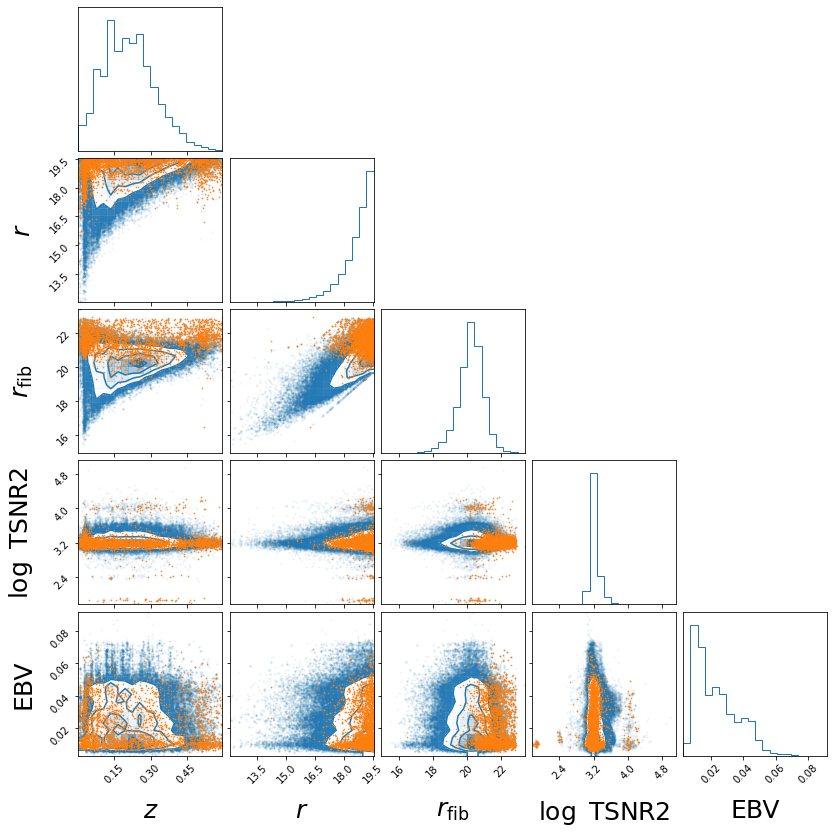

In [9]:
fig = DFM.corner(np.array([ff['Z'], rmag, rfib, np.log10(ff['TSNR2_BGS']), ff['EBV']]).T, 
                 color='C0', hist_kwargs={'density': True}, 
                 labels=[r'$z$', r'$r$', r'$r_{\rm fib}$', r'$\log$ TSNR2', 'EBV'], label_kwargs={'fontsize': 25})
DFM.overplot_points(fig, np.array([ff['Z'], rmag, rfib, np.log10(ff['TSNR2_BGS']), ff['EBV']]).T[~zsuccess], color='C1', markersize=1)
#DFM.overplot_points(fig, np.array([ff['Z'], rmag, rfib, np.log10(ff['TSNR2_BGS']), ff['EBV']]).T[~zsuccess & (np.log10(ff['TSNR2_BGS']) > 3.75)],
#                    color='r', markersize=5)
#DFM.overplot_points(fig, np.array([ff['Z'], rmag, rfib, np.log10(ff['TSNR2_BGS']), ff['EBV']]).T[~zsuccess & (np.log10(ff['TSNR2_BGS']) < 2.4)],
#                    color='green', markersize=5)

(1.5, 5.0)

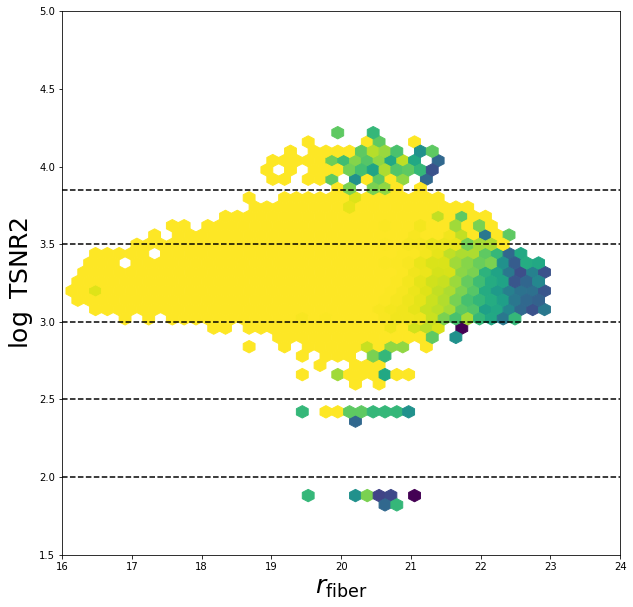

In [10]:
plt.figure(figsize=(10,10))
plt.hexbin(rfib, np.log10(ff['TSNR2_BGS']), C=zsuccess, reduce_C_function=np.mean, 
           gridsize=50, vmin=0.0, vmax=1, mincnt=2)
plt.plot([16, 24], [2.0, 2.0], c='k', ls='--')
plt.plot([16, 24], [2.5, 2.5], c='k', ls='--')
plt.plot([16, 24], [3.0, 3.0], c='k', ls='--')
plt.plot([16, 24], [3.5, 3.5], c='k', ls='--')
plt.plot([16, 24], [3.85, 3.85], c='k', ls='--')
plt.xlabel(r'$r_{\rm fiber}$', fontsize=25)
plt.xlim(16, 24)
plt.ylabel(r'$\log$ TSNR2', fontsize=25)
plt.ylim(1.5, 5.)

it seems that the $r_{\rm fib}$ dependence is different in $\log {\rm TSNR2}$ bins, so lets split it up.

In [11]:
def zsuccess_rate(prop, zsuccess_cond, range=None, nbins=20, bin_min=2):
    ''' measure the redshift success rate along with property `prop`
    :params prop: 
        array of properties (i.e. Legacy r-band magnitude) 
    :params zsuccess_cond:
        boolean array indicating redshift success 
    :params range: (default: None) 
        range of the `prop` 
    :params nbins: (default: 20) 
        number of bins to divide `prop` by 
    
    :params bin_min: (default: 2)  
        minimum number of objects in bin to exlcude it 
    :return wmean: 
        weighted mean of `prop` in the bins 
    :return e1: 
        redshift success rate in the bins
    :return ee1: 
        simple poisson error on the success rate
    '''
    h0, bins = np.histogram(prop, bins=nbins, range=range)
    hv, _ = np.histogram(prop, bins=bins, weights=prop)
    h1, _ = np.histogram(prop[zsuccess_cond], bins=bins)
    
    good = h0 > bin_min
    hv = hv[good]
    h0 = h0[good]
    h1 = h1[good]

    wmean = hv / h0 # weighted mean 
    rate = h1.astype("float") / (h0.astype('float') + (h0==0))
    e_rate = np.sqrt(rate * (1 - rate)) / np.sqrt(h0.astype('float') + (h0 == 0))
    return wmean, rate, e_rate

73 0.3972602739726027
63 0.7301587301587301
1083 0.9695290858725761
225319 0.9835743989632476
6805 0.9950036737692873
487 0.8254620123203286


Text(0, 0.5, '$z$ success rate')

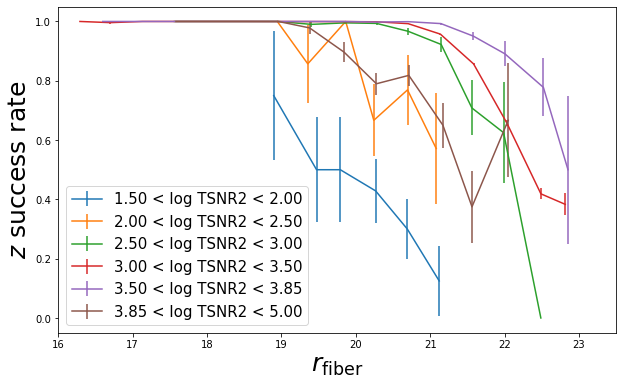

In [12]:
rfib_bin = np.linspace(16, 25, 21)

plt.figure(figsize=(10,6))
for i, logtsnr0, logtsnr1 in zip(range(6), [1.5, 2.0, 2.5, 3.0, 3.5, 3.85], [2.0, 2.5, 3.0, 3.5, 3.85, 5.0]):
    logtsnr_lim = (np.log10(ff['TSNR2_BGS']) > logtsnr0) & (np.log10(ff['TSNR2_BGS']) < logtsnr1)
    print(np.sum(logtsnr_lim), np.mean(zsuccess[logtsnr_lim]))
    
    rfib_mid, zsrate, e_zsrate = zsuccess_rate(rfib[logtsnr_lim], zsuccess[logtsnr_lim], range=(16, 25), nbins=20, bin_min=2)
    plt.errorbar(rfib_mid, zsrate, yerr=e_zsrate, color='C%i' % i, label='%.2f < log TSNR2 < %.2f' % (logtsnr0, logtsnr1))
plt.legend(loc='lower left', fontsize=15)
plt.xlabel(r'$r_{\rm fiber}$', fontsize=25)
plt.xlim(16, 23.5)
plt.ylabel('$z$ success rate', fontsize=25) 

The $z$ success rate takes on an error function like distribution. Lets fit the coefficients by minimizing $\chi^2$. In detail, this is incorrect since the likelihood wouldn't be Gaussian

In [13]:
def func_zsuccess(rfib, c_erf0, c_erf1): 
    return 0.5*(1-erf(c_erf0*(rfib - c_erf1)))

def chi2(c_erfs, rfib, zsrate, e_zsrate): 
    c_erf0, c_erf1 = c_erfs
    return np.sum((zsrate - func_zsuccess(rfib, c_erf0, c_erf1))**2/e_zsrate)  

[ 0.44272063 19.74061434]
[ 0.66805582 21.30081137]
[ 0.88776415 22.14867207]
[ 0.8221052  22.42917267]
[ 0.69773899 23.28073097]
[ 0.46515503 21.80421925]


Text(0, 0.5, '$z$ success rate')

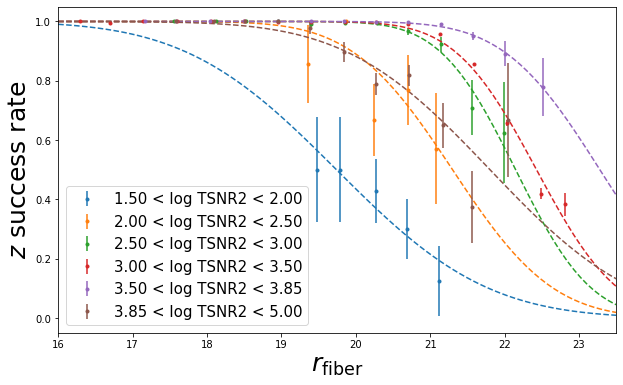

In [14]:
rfib_bin = np.linspace(16, 25, 101)

c_erf0s, c_erf1s = [], []

plt.figure(figsize=(10,6))
for i, logtsnr0, logtsnr1 in zip(range(6), [1.5, 2.0, 2.5, 3.0, 3.5, 3.85], [2.0, 2.5, 3.0, 3.5, 3.85, 5.0]):

    logtsnr_lim = (np.log10(ff['TSNR2_BGS']) > logtsnr0) & (np.log10(ff['TSNR2_BGS']) < logtsnr1)
    
    rfib_mid, zsrate, e_zsrate = zsuccess_rate(rfib[logtsnr_lim], zsuccess[logtsnr_lim], range=(16, 25), nbins=20, bin_min=5)
    plt.errorbar(rfib_mid, zsrate, yerr=e_zsrate, fmt='.C%i' % i, label='%.2f < log TSNR2 < %.2f' % (logtsnr0, logtsnr1))
    
    min_result = op.minimize(chi2, np.array([1., 22.]), 
                             args=(rfib_mid, zsrate, e_zsrate.clip(0.05, None)))
    print(min_result['x'])
    plt.plot(rfib_bin, func_zsuccess(rfib_bin, min_result['x'][0], min_result['x'][1]), c='C%i' % i, ls='--')
    c_erf0s.append(min_result['x'][0])
    c_erf1s.append(min_result['x'][1])
    
plt.legend(loc='lower left', fontsize=15)
plt.xlabel(r'$r_{\rm fiber}$', fontsize=25)
plt.xlim(16, 23.5)
plt.ylabel('$z$ success rate', fontsize=25) 

Eh. Good enough!

Lets save these to file for figures in the appendix

In [97]:
# I hate structured np.arrays
new_dt = np.dtype(ff.dtype.descr + [('rmag', np.float64), ('rfib', np.float64), ('zsuccess', bool)])
newff = np.zeros(ff.shape, dtype=new_dt)

for name in ff.dtype.names: 
    newff[name] = ff[name]
newff['rmag'] = rmag
newff['rfib'] = rfib
newff['zsuccess'] = zsuccess

fitsio.write('/global/cfs/cdirs/desi/users/chahah/provabgs/svda/ztile-sv3-bright-cumulative-bgsbright.fits', newff)

In [16]:
def fzsuccess_rfib_tsnrbin(rfib, tsnr): 
    logtsnr = np.log10(tsnr)
    
    fz = np.zeros(len(tsnr))
    for logtsnr0, logtsnr1, c_erf0, c_erf1 in zip([1.5, 2.0, 2.5, 3.0, 3.5, 3.85], [2.0, 2.5, 3.0, 3.5, 3.85, 5.0], c_erf0s, c_erf1s):    
        
        logtsnr_lim = (logtsnr > logtsnr0) & (logtsnr < logtsnr1)
        if np.sum(logtsnr_lim) > 0: 
            fz[logtsnr_lim] = 0.5*(1-erf(c_erf0*(rfib[logtsnr_lim] - c_erf1)))
    return fz

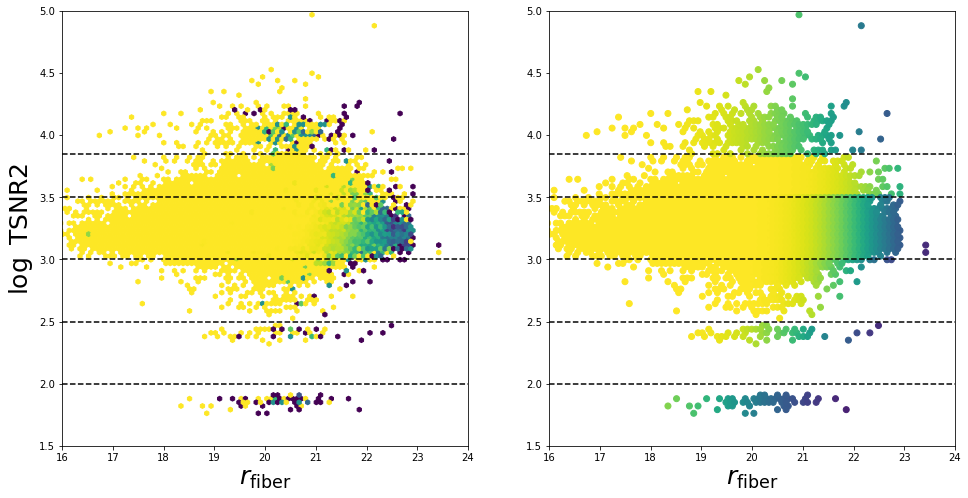

In [17]:
fig = plt.figure(figsize=(16, 8))
sub = fig.add_subplot(121)
hexes = sub.hexbin(rfib, np.log10(ff['TSNR2_BGS']), C=zsuccess, reduce_C_function=np.mean, 
           gridsize=100, vmin=0.0, vmax=1)
sub.plot([16, 24], [2.0, 2.0], c='k', ls='--')
sub.plot([16, 24], [2.5, 2.5], c='k', ls='--')
sub.plot([16, 24], [3.0, 3.0], c='k', ls='--')
sub.plot([16, 24], [3.5, 3.5], c='k', ls='--')
sub.plot([16, 24], [3.85, 3.85], c='k', ls='--')
sub.set_xlabel(r'$r_{\rm fiber}$', fontsize=25)
sub.set_xlim(16, 24)
sub.set_ylabel(r'$\log$ TSNR2', fontsize=25)
sub.set_ylim(1.5, 5.)

xy_bin = hexes.get_offsets()
rfib_bin, log_tsnr_bin = xy_bin[:,0], xy_bin[:,1]

sub = fig.add_subplot(122)
sub.scatter(rfib_bin, log_tsnr_bin, c=fzsuccess_rfib_tsnrbin(rfib_bin, 10**log_tsnr_bin), vmin=0., vmax=1)
sub.plot([16, 24], [2.0, 2.0], c='k', ls='--')
sub.plot([16, 24], [2.5, 2.5], c='k', ls='--')
sub.plot([16, 24], [3.0, 3.0], c='k', ls='--')
sub.plot([16, 24], [3.5, 3.5], c='k', ls='--')
sub.plot([16, 24], [3.85, 3.85], c='k', ls='--')
sub.set_xlabel(r'$r_{\rm fiber}$', fontsize=25)
sub.set_xlim(16, 24)
sub.set_ylim(1.5, 5.)
plt.show()

100%|██████████| 4184/4184 [00:05<00:00, 798.83it/s]


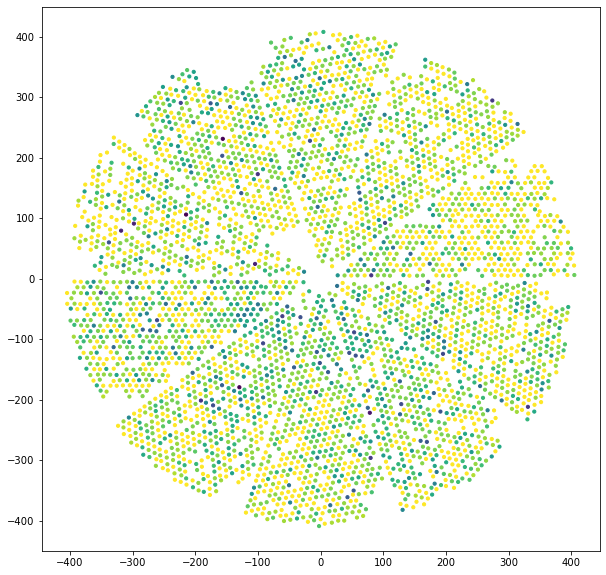

In [18]:
ufid = np.unique(ff['FIBER'])

fid_zsuccess = []
fid_x, fid_y = [], [] 
for fid in tqdm.tqdm(ufid): 
    is_fid = (ff['FIBER'] == fid)
    fid_x.append(np.median(ff['MEAN_FIBER_X'][is_fid]))
    fid_y.append(np.median(ff['MEAN_FIBER_Y'][is_fid]))
    fid_zsuccess.append(np.mean(zsuccess[is_fid]))

fig = plt.figure(figsize=(10,10))
sub = fig.add_subplot(111)
sub.scatter(fid_x, fid_y, s=10, c=fid_zsuccess, vmin=0.9, vmax=1.)

# BGS Faint

In [19]:
# file from /global/cfs/cdirs/desi/spectro/redux/everest/zcatalog/ztile-sv3-bright-cumulative.fits
# fuji couldn't be downloaded for some reason
ff = fitsio.read('/global/cfs/cdirs/desi/spectro/redux/fuji/zcatalog/ztile-sv3-bright-cumulative.fits')

# select only BGS targets
is_bgs = ((ff['COADD_FIBERSTATUS'] == 0) & 
          ((ff['SV3_BGS_TARGET'] & sv3_bgs_mask['BGS_FAINT']) != 0) & 
          (ff['SPECTYPE'] == 'GALAXY') & 
          (ff['Z'] > 0.) & (ff['Z'] < 0.6))
ff = ff[is_bgs]
print('%i objects' % ff.shape[0])

163122 objects


In [20]:
zsuccess = ((ff['ZWARN'] == 0) & 
            (ff['DELTACHI2'] > 40.) & 
            (ff['ZERR'] < 0.0005 * (1 + ff['Z'])))
print('%i z-success' % np.sum(zsuccess))

160869 z-success


In [21]:
photsys = ff['PHOTSYS'].astype(str)
trans_g = SVDA.mwdust_transmission(ff['EBV'], 'g', photsys, match_legacy_surveys=False)
trans_r = SVDA.mwdust_transmission(ff['EBV'], 'r', photsys, match_legacy_surveys=False)
trans_z = SVDA.mwdust_transmission(ff['EBV'], 'z', photsys, match_legacy_surveys=False)
trans_w = SVDA.mwdust_transmission(ff['EBV'], 'w1', photsys, match_legacy_surveys=False)

flux_g = ff['FLUX_G'] / trans_g
flux_r = ff['FLUX_R'] / trans_r
flux_z = ff['FLUX_Z'] / trans_z
flux_w = ff['FLUX_W1'] / trans_w
fiberflux_r = ff['FIBERFLUX_R'] / trans_r

gmag = 22.5 - 2.5 * np.log10(flux_g.clip(1e-7))
rmag = 22.5 - 2.5 * np.log10(flux_r.clip(1e-7))
zmag = 22.5 - 2.5 * np.log10(flux_z.clip(1e-7))
wmag = 22.5 - 2.5 * np.log10(flux_w.clip(1e-7))

rfib = 22.5 - 2.5 * np.log10(fiberflux_r.clip(1e-7))

schlegel_color = (zmag - wmag) - 3/2.5 * (gmag - rmag) + 1.2

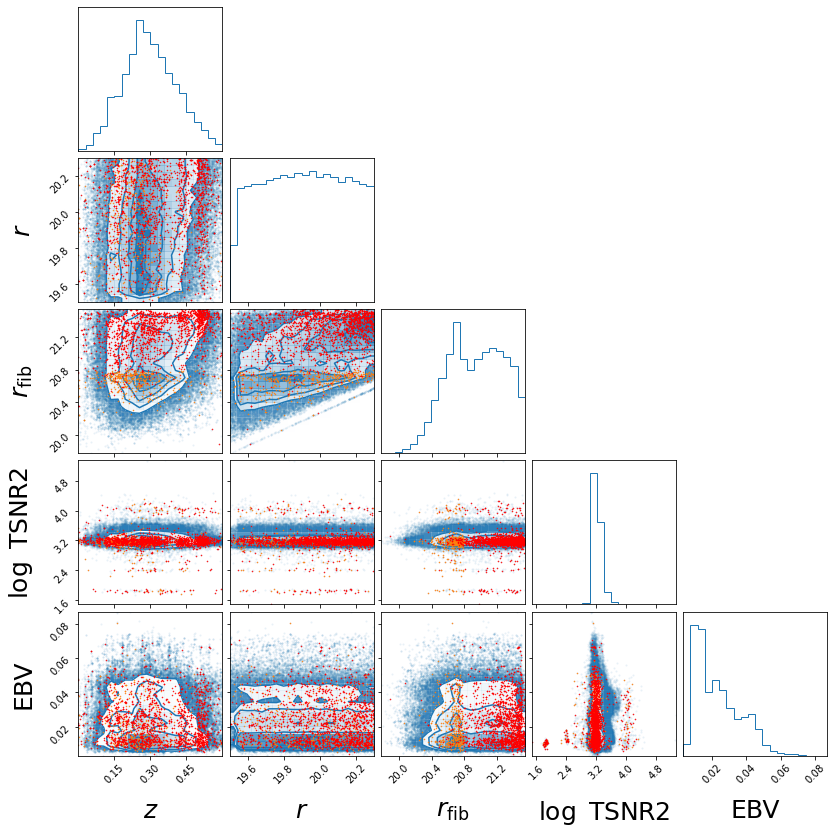

In [22]:
fig = DFM.corner(np.array([ff['Z'], rmag, rfib, np.log10(ff['TSNR2_BGS']), ff['EBV']]).T, 
                 color='C0', hist_kwargs={'density': True}, 
                 labels=[r'$z$', r'$r$', r'$r_{\rm fib}$', r'$\log$ TSNR2', 'EBV'], label_kwargs={'fontsize': 25})
DFM.overplot_points(fig, np.array([ff['Z'], rmag, rfib, np.log10(ff['TSNR2_BGS']), ff['EBV']]).T[~zsuccess & (schlegel_color < 0)], 
                    color='C1', markersize=1)
DFM.overplot_points(fig, np.array([ff['Z'], rmag, rfib, np.log10(ff['TSNR2_BGS']), ff['EBV']]).T[~zsuccess & (schlegel_color > 0)], 
                    color='r', markersize=1)

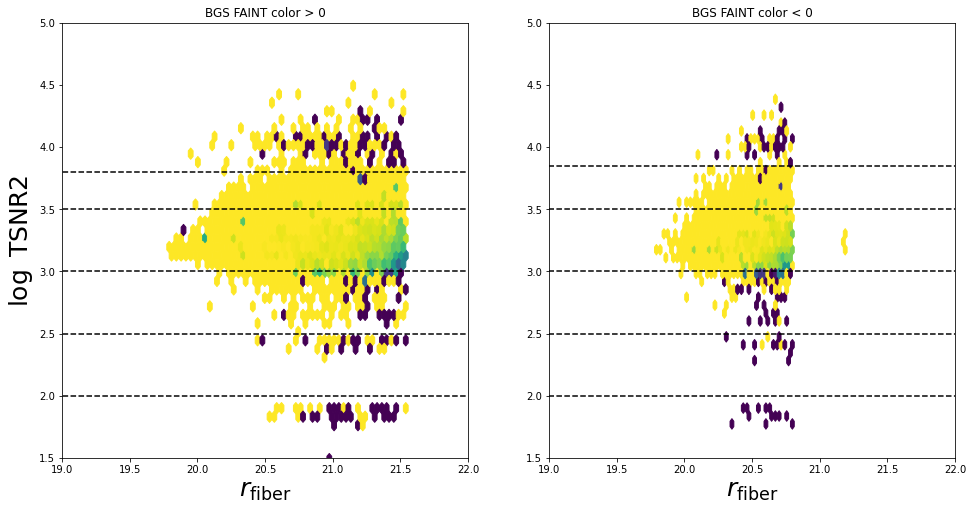

In [26]:
fig = plt.figure(figsize=(16, 8))
sub = fig.add_subplot(121)
sub.hexbin(rfib[schlegel_color > 0], np.log10(ff['TSNR2_BGS'])[schlegel_color > 0], 
           C=zsuccess[schlegel_color > 0], reduce_C_function=np.mean, 
           gridsize=50, vmin=0.8, vmax=1)
sub.plot([16, 24], [2.0, 2.0], c='k', ls='--')
sub.plot([16, 24], [2.5, 2.5], c='k', ls='--')
sub.plot([16, 24], [3.0, 3.0], c='k', ls='--')
sub.plot([16, 24], [3.5, 3.5], c='k', ls='--')
sub.plot([16, 24], [3.8, 3.8], c='k', ls='--')
sub.set_xlabel(r'$r_{\rm fiber}$', fontsize=25)
sub.set_xlim(19, 22)
sub.set_ylabel(r'$\log$ TSNR2', fontsize=25)
sub.set_ylim(1.5, 5.)
sub.set_title('BGS FAINT color > 0')

sub = fig.add_subplot(122)
sub.hexbin(rfib[schlegel_color < 0], np.log10(ff['TSNR2_BGS'])[schlegel_color < 0], 
           C=zsuccess[schlegel_color < 0], reduce_C_function=np.mean, 
           gridsize=50, vmin=0.8, vmax=1)
sub.plot([16, 24], [2.0, 2.0], c='k', ls='--')
sub.plot([16, 24], [2.5, 2.5], c='k', ls='--')
sub.plot([16, 24], [3.0, 3.0], c='k', ls='--')
sub.plot([16, 24], [3.5, 3.5], c='k', ls='--')
sub.plot([16, 24], [3.85, 3.85], c='k', ls='--')
sub.set_xlabel(r'$r_{\rm fiber}$', fontsize=25)
sub.set_xlim(19, 22)
sub.set_ylim(1.5, 5.)
sub.set_title('BGS FAINT color < 0')
plt.show()

## lets first focus on `schlegel_color > 0`

[ 1.67163017 21.14342871]
[ 1.6478732  21.79206685]
[ 1.49206734 22.09573976]
[ 1.31762355 22.33046202]
[ 1.3281991  22.40893427]
[ 0.90687631 23.09747128]
[ 1.02655811 23.02003987]
[ 0.92365139 21.6161412 ]


Text(0, 0.5, '$z$ success rate')

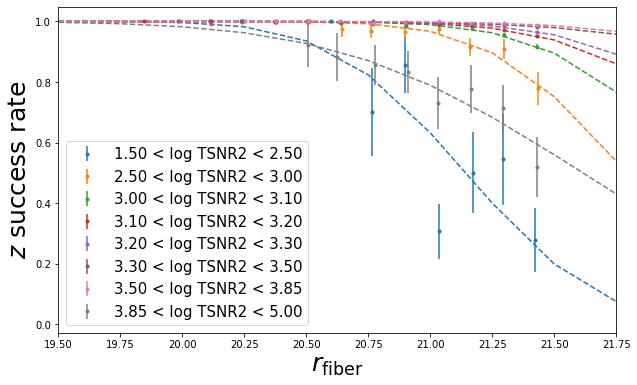

In [64]:
def func_zsuccess(rfib, c_erf0, c_erf1): 
    return 0.5*(1-erf(c_erf0*(rfib - c_erf1)))

def chi2(c_erfs, rfib, zsrate, e_zsrate): 
    c_erf0, c_erf1 = c_erfs
    return np.sum((zsrate - func_zsuccess(rfib, c_erf0, c_erf1))**2/e_zsrate)  

rfib_bin = np.linspace(19.5, 22.0, 11)

logtsnr_min_em = [1.5, 2.5, 3., 3.1, 3.2, 3.3, 3.5, 3.85]
logtsnr_max_em = [2.5, 3.0, 3.1, 3.2, 3.3, 3.5, 3.85, 5.0]
c0s_faint, c1s_faint = [], []

plt.figure(figsize=(10,6))
for i, logtsnr0, logtsnr1 in zip(range(9), logtsnr_min_em, logtsnr_max_em):

    logtsnr_lim = (np.log10(ff['TSNR2_BGS']) > logtsnr0) & (np.log10(ff['TSNR2_BGS']) < logtsnr1) & (schlegel_color > 0)
    
    rfib_mid, zsrate, e_zsrate = zsuccess_rate(rfib[logtsnr_lim], zsuccess[logtsnr_lim], range=(19.5, 21.5), nbins=15, bin_min=5)
    plt.errorbar(rfib_mid, zsrate, yerr=e_zsrate, fmt='.C%i' % i, label='%.2f < log TSNR2 < %.2f' % (logtsnr0, logtsnr1))
    
    min_result = op.minimize(chi2, np.array([1., 22.]), 
                             args=(rfib_mid, zsrate, e_zsrate.clip(0.05, None)))
    print(min_result['x'])
    plt.plot(rfib_bin, func_zsuccess(rfib_bin, min_result['x'][0], min_result['x'][1]), c='C%i' % i, ls='--')
    c0s_faint.append(min_result['x'][0])
    c1s_faint.append(min_result['x'][1])
    
plt.legend(loc='lower left', fontsize=15)
plt.xlabel(r'$r_{\rm fiber}$', fontsize=25)
plt.xlim(19.5, 21.75)
plt.ylabel('$z$ success rate', fontsize=25) 

## now on `schlegel_color < 0`

[ 1.47794757 20.92275801]
[ 2.40488178 21.16670108]
[ 1.30053995 21.80779297]
[ 1.26645044 21.98731592]
[ 1.83089418 21.66870409]
[ 0.79824946 22.89227465]
[ 1.2882063  20.63296212]


Text(0, 0.5, '$z$ success rate')

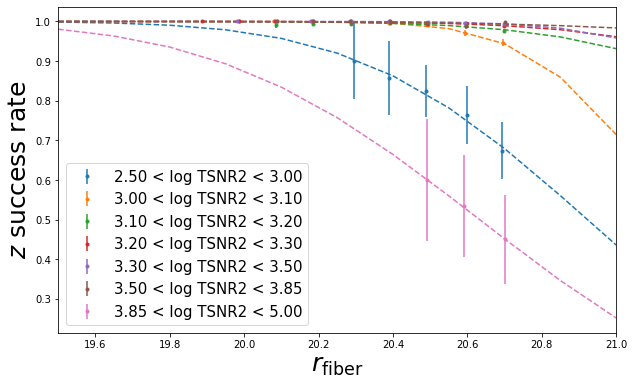

In [65]:
rfib_bin = np.linspace(19.5, 21.0, 11)

logtsnr_min_noem = [2.5, 3., 3.1, 3.2, 3.3, 3.5, 3.85]
logtsnr_max_noem = [3.0, 3.1, 3.2, 3.3, 3.5, 3.85, 5.0]
c0s_faint_noem, c1s_faint_noem = [], []

plt.figure(figsize=(10,6))
for i, logtsnr0, logtsnr1 in zip(range(12), logtsnr_min_noem, logtsnr_max_noem):

    logtsnr_lim = (np.log10(ff['TSNR2_BGS']) > logtsnr0) & (np.log10(ff['TSNR2_BGS']) < logtsnr1) & (schlegel_color < 0)
    
    rfib_mid, zsrate, e_zsrate = zsuccess_rate(rfib[logtsnr_lim], zsuccess[logtsnr_lim], range=(19.5, 20.75), nbins=12, bin_min=5)
    plt.errorbar(rfib_mid, zsrate, yerr=e_zsrate, fmt='.C%i' % i, label='%.2f < log TSNR2 < %.2f' % (logtsnr0, logtsnr1))
    
    min_result = op.minimize(chi2, np.array([1., 22.]), 
                             args=(rfib_mid, zsrate, e_zsrate.clip(0.05, None)))
    print(min_result['x'])
    plt.plot(rfib_bin, func_zsuccess(rfib_bin, min_result['x'][0], min_result['x'][1]), c='C%i' % i, ls='--')
    c0s_faint_noem.append(min_result['x'][0])
    c1s_faint_noem.append(min_result['x'][1])
    
plt.legend(loc='lower left', fontsize=15)
plt.xlabel(r'$r_{\rm fiber}$', fontsize=25)
plt.xlim(19.5, 21.0)
plt.ylabel('$z$ success rate', fontsize=25) 

In [74]:
np.array(c10s_faint_noem)

array([1.47794757, 2.40488178, 1.30053995, 1.26645044, 1.83089418,
       0.79824946, 1.2882063 ])

In [68]:
def fzsuccess_rfib_tsnrbin_faint_emline(rfib, tsnr): 
    logtsnr = np.log10(tsnr)
    
    fz = np.zeros(len(tsnr))
    for logtsnr0, logtsnr1, c_erf0, c_erf1 in zip(logtsnr_min_em, logtsnr_max_em, c0s_faint, c1s_faint): 
        logtsnr_lim = (logtsnr > logtsnr0) & (logtsnr < logtsnr1)
        if np.sum(logtsnr_lim) > 0: 
            fz[logtsnr_lim] = 0.5*(1-erf(c_erf0*(rfib[logtsnr_lim] - c_erf1)))
    return fz

def fzsuccess_rfib_tsnrbin_faint_noemline(rfib, tsnr): 
    logtsnr = np.log10(tsnr)
    
    fz = np.zeros(len(tsnr))
    for logtsnr0, logtsnr1, c_erf0, c_erf1 in zip(logtsnr_min_noem, logtsnr_max_noem, c0s_faint_noem, c1s_faint_noem): 
        logtsnr_lim = (logtsnr > logtsnr0) & (logtsnr < logtsnr1)
        if np.sum(logtsnr_lim) > 0: 
            fz[logtsnr_lim] = 0.5*(1-erf(c_erf0*(rfib[logtsnr_lim] - c_erf1)))
    return fz

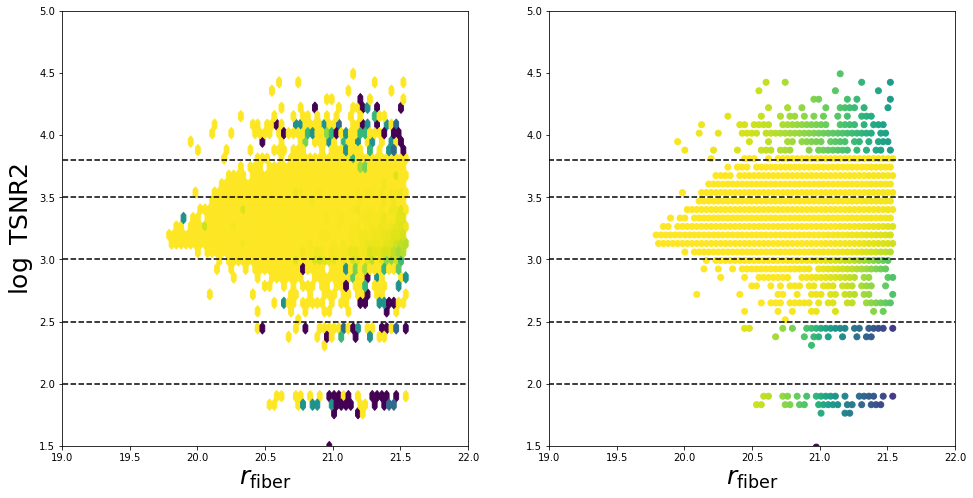

In [69]:
fig = plt.figure(figsize=(16, 8))
sub = fig.add_subplot(121)
hexes = sub.hexbin(rfib[schlegel_color > 0], np.log10(ff['TSNR2_BGS'])[schlegel_color > 0], 
           C=zsuccess[schlegel_color > 0], reduce_C_function=np.mean, 
           gridsize=50, vmin=0., vmax=1)
sub.plot([16, 24], [2.0, 2.0], c='k', ls='--')
sub.plot([16, 24], [2.5, 2.5], c='k', ls='--')
sub.plot([16, 24], [3.0, 3.0], c='k', ls='--')
sub.plot([16, 24], [3.5, 3.5], c='k', ls='--')
sub.plot([16, 24], [3.8, 3.8], c='k', ls='--')
sub.set_xlabel(r'$r_{\rm fiber}$', fontsize=25)
sub.set_xlim(19, 22)
sub.set_ylabel(r'$\log$ TSNR2', fontsize=25)
sub.set_ylim(1.5, 5.)

xy_bin = hexes.get_offsets()
rfib_bin, log_tsnr_bin = xy_bin[:,0], xy_bin[:,1]

sub = fig.add_subplot(122)
sub.scatter(rfib_bin, log_tsnr_bin, c=fzsuccess_rfib_tsnrbin_faint_emline(rfib_bin, 10**log_tsnr_bin), vmin=0.0, vmax=1)
sub.plot([16, 24], [2.0, 2.0], c='k', ls='--')
sub.plot([16, 24], [2.5, 2.5], c='k', ls='--')
sub.plot([16, 24], [3.0, 3.0], c='k', ls='--')
sub.plot([16, 24], [3.5, 3.5], c='k', ls='--')
sub.plot([16, 24], [3.8, 3.8], c='k', ls='--')
sub.set_xlabel(r'$r_{\rm fiber}$', fontsize=25)
sub.set_xlim(19, 22)
sub.set_ylim(1.5, 5.)
plt.show()

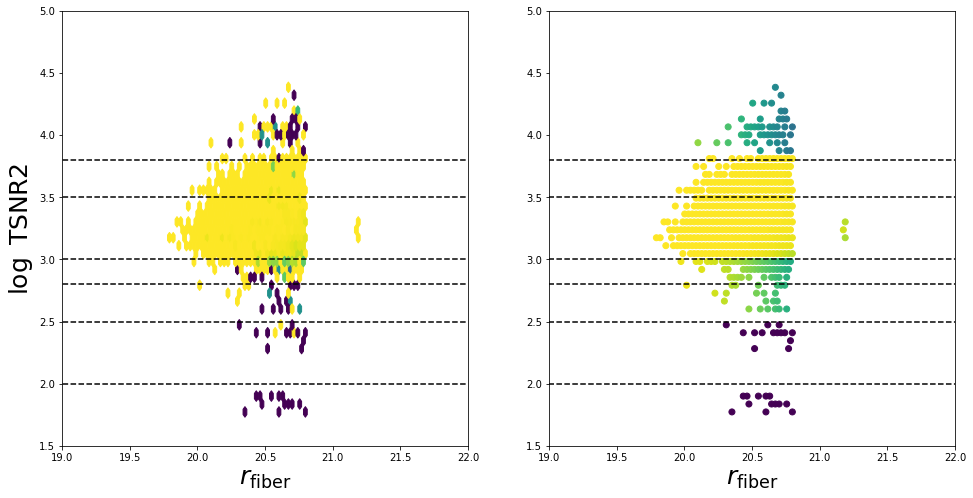

In [70]:
fig = plt.figure(figsize=(16, 8))
sub = fig.add_subplot(121)
hexes = sub.hexbin(rfib[schlegel_color < 0], np.log10(ff['TSNR2_BGS'])[schlegel_color < 0], 
           C=zsuccess[schlegel_color < 0], reduce_C_function=np.mean, 
           gridsize=50, vmin=0.0, vmax=1)
sub.plot([16, 24], [2.0, 2.0], c='k', ls='--')
sub.plot([16, 24], [2.5, 2.5], c='k', ls='--')
sub.plot([16, 24], [2.8, 2.8], c='k', ls='--')
sub.plot([16, 24], [3.0, 3.0], c='k', ls='--')
sub.plot([16, 24], [3.5, 3.5], c='k', ls='--')
sub.plot([16, 24], [3.8, 3.8], c='k', ls='--')
sub.set_xlabel(r'$r_{\rm fiber}$', fontsize=25)
sub.set_xlim(19, 22)
sub.set_ylabel(r'$\log$ TSNR2', fontsize=25)
sub.set_ylim(1.5, 5.)

xy_bin = hexes.get_offsets()
rfib_bin, log_tsnr_bin = xy_bin[:,0], xy_bin[:,1]

sub = fig.add_subplot(122)
sub.scatter(rfib_bin, log_tsnr_bin, c=fzsuccess_rfib_tsnrbin_faint_noemline(rfib_bin, 10**log_tsnr_bin), 
            vmin=0.0, vmax=1)
sub.plot([16, 24], [2.0, 2.0], c='k', ls='--')
sub.plot([16, 24], [2.5, 2.5], c='k', ls='--')
sub.plot([16, 24], [2.8, 2.8], c='k', ls='--')
sub.plot([16, 24], [3.0, 3.0], c='k', ls='--')
sub.plot([16, 24], [3.5, 3.5], c='k', ls='--')
sub.plot([16, 24], [3.8, 3.8], c='k', ls='--')
sub.set_xlabel(r'$r_{\rm fiber}$', fontsize=25)
sub.set_xlim(19, 22)
sub.set_ylim(1.5, 5.)
plt.show()